In [1]:
import pandas, numpy, seaborn, sklearn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

## functions & options


In [2]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# I] Dataframe settings

In [42]:
%%time
#Open the big expression data with all the transcripts in 3 parts. Chunksize is number of rows.
path = input_file_directory + "/xenabrowser_brut_data/all_transcripts/gtex_Kallisto_tpm.tsv"
df, df2, df3 = pandas.read_csv(path, sep = "\t", index_col='sample', 
                                chunksize=65700, iterator=True)

print(df.shape, df2.shape, df3.shape)

MemoryError: Unable to allocate 3.85 GiB for an array with shape (7862, 65644) and data type float64

In [43]:
# 1st part
df.index.name = None
#to tpm
df = 2**df
#to log2(tpm+1)
df = numpy.log2(df+1)
#be sure nothing is lower than 0
df.min().min()

MemoryError: Unable to allocate 2.72 GiB for an array with shape (46489, 7863) and data type float64

In [ ]:
# 2nd part
df2.index.name = None
#to tpm
df2 = 2**df2
#to log2(tpm+1)
df2 = numpy.log2(df2+1)
#be sure nothing is lower than 0
df2.min().min()

In [ ]:
#3rd part
df3.index.name = None
#to tpm
df3 = 2**df3
#to log2(tpm+1)
df3 = numpy.log2(df3+1)
#be sure nothing is lower than 0
df3.min().min()

In [15]:
#concat the 3 dataframes
df = pandas.concat([df, df2, df3], axis=0)
df.shape

(197044, 7862)

In [19]:
genes = "ENST00000354449.7", "ENST00000354956.9"
g_names = "ATG7_1", "ATG7_2"
for i in range(len(genes)):
    print(f'{g_names[i]}: {df.loc[genes[i], :].sum()}')

ATG7_1: 20716.240270989892
ATG7_2: 8104.745972245537


In [20]:
%%time
ATG7_2_sum = 8104.73

print('shape before filtering', df.shape)
#create boolean and select the genes where sum is higher than ATG7(2) sum expression
bool_higher_iso2 = df.sum(axis=1) > ATG7_2_sum 
df = df[bool_higher_iso2]

print('shape after filtering', df.shape)

shape before filtering (197044, 7862)
shape after filtering (46489, 7862)


In [21]:
%%time
#evaluate the goodness score for each cluster to select the best possibility.
cluster_numbers = list(range(2, 20))
number_clust_L = [] 
goodness_chs_L = []
goodness_dbi_L = []
for nb in cluster_numbers:
    kmeans_model = KMeans(n_clusters = nb, random_state=1).fit(df)
    labels = kmeans_model.labels_
    goodness_chs = metrics.calinski_harabasz_score(df, labels)
    goodness_dbi = metrics.davies_bouldin_score(df, labels)
    
    #save score in list
    number_clust_L.append(nb)
    goodness_chs_L.append(goodness_chs)
    goodness_dbi_L.append(goodness_dbi)

#convert to dict then to DF
d = dict(Number = number_clust_L, Goodness_CHS = goodness_chs_L, Goodness_DBI = goodness_dbi_L)
df_goodness = pandas.DataFrame.from_dict(d, orient='columns')
df_goodness.head()

Wall time: 1h 13min 22s


,Number,Goodness_CHS,Goodness_DBI
0,2,30043.903371,1.008159
1,3,23221.134670,1.246113
2,4,18732.166954,1.448772
3,5,15529.636186,1.671612
4,6,13144.940636,1.913011


the elbow curve is at between 7 and 10


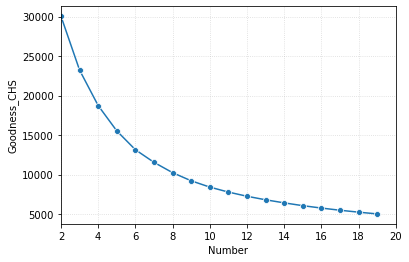

In [39]:
#plot the Goodness on the number to determine the best one.
##calinski_harabasz_score
seaborn.lineplot(data = df_goodness, x = 'Number', y = 'Goodness_CHS', marker="o")
plt.grid(ls=':', alpha = 0.5)
plt.xlim(2,20)
print('the elbow curve is at between 7 and 10')

the plateau start at 9


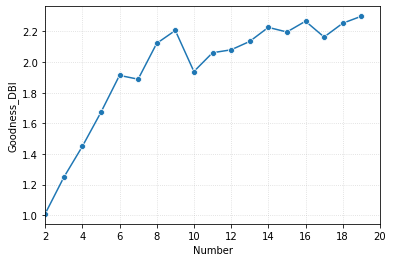

In [40]:
#davies_bouldin_score
seaborn.lineplot(data = df_goodness, x = 'Number', y = 'Goodness_DBI', marker="o")
plt.grid(ls=':', alpha = 0.5)
plt.xlim(2,20)
print('the plateau start at 9')

In [27]:
%%time
# 9 is the best number of cluster
kmeans_model = KMeans(n_clusters = 9, random_state=1).fit(df)
# Find what cluster for each gene
pred_cluster = kmeans_model.predict(df)
print(pred_cluster)
#add the prediction in a column
df['cluster'] = pred_cluster
df.head()

[7 5 4 ... 4 7 4]


<ipython-input-27-50c216617f80>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_11'] = pred_cluster


,GTEX-S4Q7-0003-SM-3NM8M,GTEX-QV31-1626-SM-2S1QC,GTEX-13OW5-0626-SM-5J2N2,GTEX-ZPCL-0126-SM-4WWC8,GTEX-S33H-1226-SM-4AD69,GTEX-X88G-0426-SM-47JZ5,GTEX-ZAKK-0326-SM-5EGHA,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,GTEX-13W3W-2626-SM-5SIA2,...,GTEX-ZYFD-2126-SM-5E43D,GTEX-OOBK-2626-SM-2HMKY,GTEX-OHPJ-0006-SM-3LK6G,GTEX-1117F-2826-SM-5GZXL,GTEX-11ZTS-3326-SM-5LU9Y,GTEX-VJYA-0726-SM-4KL1T,GTEX-ZA64-2126-SM-5Q5A8,GTEX-Q2AG-2826-SM-2HMJQ,GTEX-XV7Q-0426-SM-4BRVN,cluster_11
ENST00000354449.7,1.754024,3.093208,2.773255,3.140363,1.760291,3.288649,2.154118,3.055050,2.928635,1.561063,...,3.095504,3.027025,1.666746,2.696437,2.794625,2.071859,3.505205,2.864142,3.801190,7
ENST00000354956.9,2.031869,1.523112,0.289911,0.581803,0.304695,0.001442,1.610205,2.098074,1.752476,0.656618,...,0.177109,0.502040,2.643758,1.746153,0.203503,2.357154,1.312013,0.281734,2.265490,5
ENST00000625998.2,2.172917,2.098457,0.605310,1.012958,1.840341,2.113273,1.961725,1.283244,2.350880,1.159992,...,0.001583,1.761842,0.001444,2.140955,2.461130,1.478752,1.540381,3.384966,2.149081,4
ENST00000583693.5,1.679926,1.660177,2.344050,2.182342,1.596586,1.608995,1.097966,2.342765,1.919648,0.946337,...,2.018141,2.313614,0.592670,1.886752,3.031413,1.152825,2.085215,3.180864,1.991561,4
ENST00000012134.6,0.029468,1.529313,1.308731,0.800025,0.098109,2.200463,1.560996,1.650962,1.646671,1.745662,...,3.450136,2.087815,0.341077,1.688054,1.888504,1.644289,1.929813,3.288559,1.385678,4


In [28]:
#ATG7 is not in the list
ATG7_1 = 'ENST00000354449.7'
ATG7_2 = 'ENST00000354956.9'

print(df['cluster'][[ATG7_1, ATG7_2]])

ENST00000354449.7    7
ENST00000354956.9    5
Name: cluster_11, dtype: int32


In [41]:
'The two genes are not in the same cluster. They are different'

'The two genes are not in the same cluster. They are different'